In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.special import gamma,loggamma
from scipy.cluster.hierarchy import dendrogram

In [222]:
%reload_ext Cython

In [ ]:
%%cython
import numpy as np
import itertools as it
from scipy.special import gammaln,gamma,loggamma
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram as dd

#%load_ext Cython
#%%cython
class Node:
    def __init__(self,data,alpha,beta=None,left=None,right=None):
        """
        Initialize a bayesian hierarchical clustering with the followin parameters.
        Data: NArray
        Alpha: Hyperparameter
        Beta: Hyperparameter
        Left: Left child node
        Right: Right child node
        """  
        self.data = data
        self.alpha = alpha
        self.beta = beta
        self.left = left
        self.right = right
        self.n_k = data.shape[0]
        """The prior probability on the merged hypothesis"""
        if left:
            self.d_k = alpha * gamma(self.n_k)+self.left.d_k * self.right.d_k
            self.pi_k = alpha * gamma(self.n_k)/self.d_k
        else:
            self.d_k = alpha
            self.pi_k = 1 

def bhc(data,alpha,beta=None):
    """ 
    This function does a bayesian clustering. 
    Alpha: Hyperparameter
    Beta: Hyperparameter
    
    If beta is not given, it uses the Multinomial-Dirichlet.
    Otherwise it uses Bernoulli-Beta.
    """
    n_cluster = data.shape[0]
    nodekey = n_cluster
    list_clusters = [i for i in range(n_cluster)]
    clusters = dict()
    clusters["n_cluster"] = n_cluster
    clusters[n_cluster] = (1,[str(i+1) for i in range(n_cluster)])
    tree = {str(i+1):Node(data=np.array([data[i,:]]),alpha=alpha,beta=beta,left=None,right=None) 
                 for i in range(n_cluster)}
    while n_cluster > 1:
        "Find the pair with the highest probability of the merged hypothesis"
        r_k_max = -1000000
        for left,right in list(it.combinations(tree.keys(), 2)):
            nodekey += 1
            aux_data = np.vstack((tree[left].data,tree[right].data))
            aux_node = Node(aux_data,alpha,beta=beta,left=tree[left],right=tree[right])
            r_k = posterior(aux_node)
            #print(r_k)
            if r_k > r_k_max:
                r_k_max = r_k
                merged_left = left
                merged_right = right
                merged_node = aux_node

        merged_node.r_k = r_k_max

        newkey = merged_left+','+ merged_right
        del tree[merged_left]
        del tree[merged_right]
        tree[newkey] = merged_node  
        n_cluster -= 1
        clusters[n_cluster] = (r_k_max,list(tree.keys()))
        nodekey +=1
    return clusters,merged_node

def posterior(node):
    """
    Calculates the posterior proabability of the merged hypothesis
    """
    return node.pi_k * prob_dH1_k(node) / prob_dT_k(node)

def prob_dT_k(node):
    """ 
    Calculates the marginal probability of the data in tree Tk
    """
    if node.left:
        return node.pi_k * prob_dH1_k(node) + (1-node.pi_k) * prob_dT_k(node.left) * prob_dT_k(node.right)
    else: 
        return node.pi_k * prob_dH1_k(node)
        
def prob_dH1_k(node):
    """
    Calculates the marginal likelihood using the following model:
        Bernoulli-Beta if beta is given.
        Multinomial-Dirichlet if only alpha is given.
    """
    N = node.data.shape[0]
    k = node.data.shape[1] 
    prob = 0
    if node.beta:
        m_d = np.sum(node.data,axis=0)
        term1 = loggamma(node.alpha+node.beta) + loggamma(node.alpha+m_d) + loggamma(node.+N-m_d)
        term2 = loggamma(node.alpha) + loggamma(node.beta) + loggamma(node.alpha+node.beta+N)      
        prob = np.exp(np.sum(term1-term2))
    else:
        alpha = np.repeat(node.alpha, k)
        coefficient = [loggamma(np.sum(node.data[i,:])+1)- np.sum(loggamma(node.data[i, :]+1)) for i in range(N)]
        term1 = np.sum(coefficient)
        sumterm = [loggamma(alpha[j] + np.sum(node.data[:,j])) - loggamma(alpha[j]) for j in range(k)]
        term2 = np.sum(sumterm)
        term3 = loggamma(np.sum(alpha))
        term4 = loggamma(np.sum(node.data) + np.sum(alpha))
        prob = np.exp(term1 + term2 + term3 -term4)
        #print("prob",prob)
    return prob

def cut_tree_n(n_clusters,clusters):
    """
    Gives the clusters number by cutting the tree with n clusters
    n_clusters: Number of clusters chosen by the user
    clusters: Dictionary with all clusters (output from bhc function)
    """
    aux_cluster = clusters[n_clusters][1]
    n = clusters["n_cluster"]
    assigments=np.zeros(n)
    for i,c in enumerate(aux_cluster):
        if len(c)>1:
            for j in c.split(","):
                assigments[int(j)-1]=i
        else:
            assigments[int(c)-1] = i 
    return assigments

def dendogram(clusters):
    """
    Builds the dendrogram matrix needed to plot it with scipy
    clusters : Dictionary with all clusters (output from bhc function)
    """
    new_cluster = {}
    obs = clusters["n_cluster"]+1
    n = clusters["n_cluster"]
    Z = np.zeros(shape=(n-1,4))
    for i in range(1,obs-1):
        old_set = set(clusters[obs-i][1])
        new_set = set(clusters[obs-(i+1)][1])
        new_node = new_set.difference(old_set)
        old_nodes = old_set.difference(new_set)
        node_a = old_nodes.pop()
        node_b = old_nodes.pop()
        node_c = new_node.pop()
        new_cluster[node_c] = n
        if "," in node_b:
            num_b = new_cluster[node_b]
        else:
            num_b = int(node_b)-1
        if "," in node_a:
            num_a = new_cluster[node_a]
        else:
            num_a = int(node_a)-1
        rk = clusters[obs-(i+1)][0]
        Z[i-1,0] = num_a
        Z[i-1,1] = num_b
        Z[i-1,2] = -np.log(rk/(1-rk))
        Z[i-1,3] = len(node_c.split(","))
        n+=1
    return Z


Spiral Dataset using Bernoulli prior

In [21]:
spiral = pd.read_csv('/Users/zhuangdiezhou/Documents/Course Spring 2019/Statistical Computation/BHC/spiral.txt', 
                     sep="\t", header=None) 

In [296]:
spiral_1 = spiral[spiral.iloc[:,2] == 1]
spiral_2 = spiral[spiral.iloc[:,2] == 2]

ar_spiral = pd.concat([spiral_1[0:10],spiral_2[0:10]])

#normalization
np_spiral = np.array(ar_spiral,dtype=None)[:, 0:2]
normed_spiral = np_spiral/np_spiral.sum(axis = 1)[:,None]

In [808]:
%%time
clusters, a=bhc(data=normed_spiral, alpha = 20,beta = 11)
assigments = cut_tree_n(2, clusters)

CPU times: user 224 ms, sys: 14.5 ms, total: 238 ms
Wall time: 226 ms


In [809]:
Z = dendrogram_data(clusters)

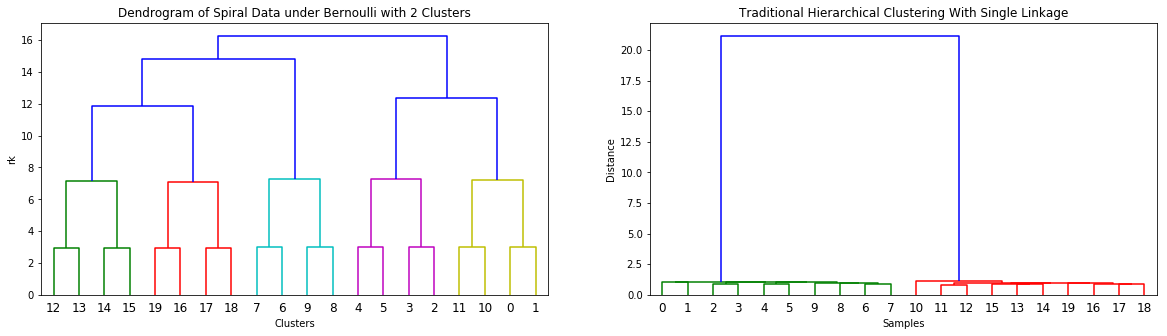

In [836]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
dendrogram(Z)
plt.xlabel('Clusters')
plt.ylabel('rk')
plt.title('Dendrogram of Spiral Data under Bernoulli with 2 Clusters')

plt.subplot(1,2,2)
data = np.array(ar_spiral)
data_dist = pdist(data) # computing the distance
data_link = linkage(data_dist,method='single') # computing the linkage
dendrogram(data_link,labels=data.dtype.names)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.title('Traditional Hierarchical Clustering With Single Linkage')
plt.show()

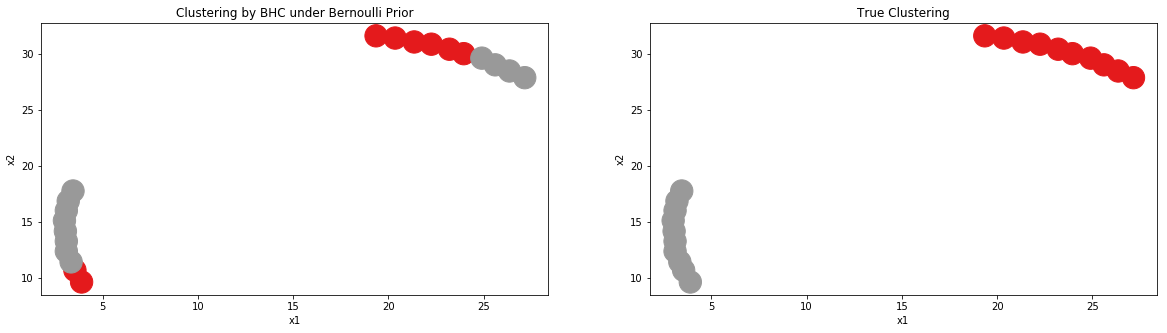

In [811]:
z = np.array(ar_spiral.iloc[0:20,2])
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.scatter(np_spiral[:, 0], np_spiral[:, 1], c=assigments, cmap='Set1',s = 500)
plt.title('Clustering by BHC under Bernoulli Prior')
plt.xlabel('x1')
plt.ylabel('x2')

plt.subplot(1,2,2)
plt.scatter(np_spiral[:, 0], np_spiral[:, 1], c=z, cmap='Set1',s = 500)
plt.title('True Clustering')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [505]:
from sklearn.metrics import f1_score
assigments[assigments == 1] = 2
assigments[assigments == 0] = 1
f1_score(z, assigments)

0.6666666666666665

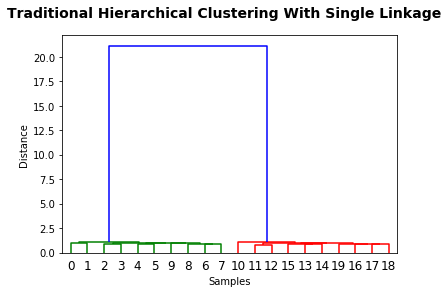

In [818]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
data = np.array(ar_spiral)
data_dist = pdist(data) # computing the distance
data_link = linkage(data_dist,method='single') # computing the linkage
dendrogram(data_link,labels=data.dtype.names)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Traditional Hierarchical Clustering With Single Linkage', fontweight='bold', fontsize=14);

Spiral Dataset using Dirichilet prior

In [514]:
spiral_1 = spiral[spiral.iloc[:,2] == 1]
spiral_2 = spiral[spiral.iloc[:,2] == 2]
spiral_3 = spiral[spiral.iloc[:,2] == 3]

In [520]:
ar_spiral_d = pd.concat([spiral_1[0:10],spiral_2[0:10],spiral_3[0:10]])
#normalization
np_spiral_d = np.array(spiral,dtype=None)[0:30, 0:2]
normed_spiral_d = np_spiral_d/np_spiral_d.sum(axis = 1)[:,None]

In [611]:
%%time
clusters_d, a_d=bhc(data=normed_spiral_d, alpha = 20)
assigments_d = cut_tree_n(3, clusters_d)

CPU times: user 2.21 s, sys: 18.5 ms, total: 2.23 s
Wall time: 2.24 s


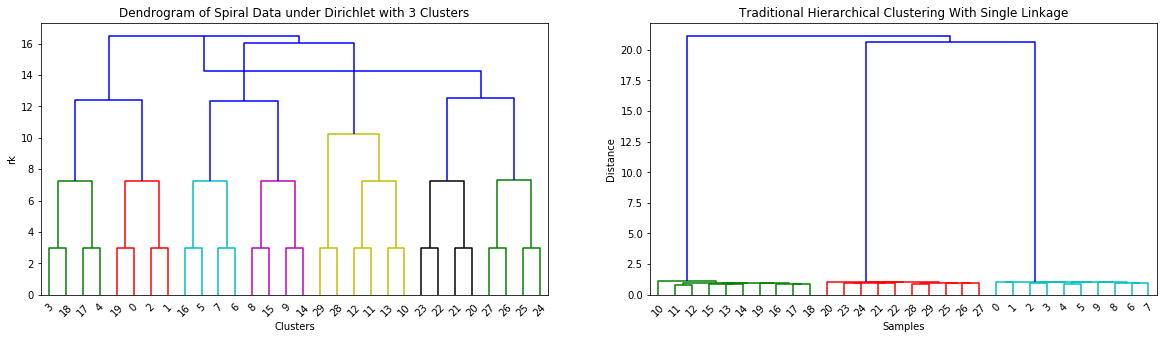

In [835]:
Zd = dendrogram_data(clusters_d)
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
dendrogram(Zd)
plt.xlabel('Clusters')
plt.ylabel('rk')
plt.title('Dendrogram of Spiral Data under Dirichlet with 3 Clusters')

plt.subplot(1,2,2)
data = np.array(ar_spiral_d)
data_dist = pdist(data) # computing the distance
data_link = linkage(data_dist,method='single') # computing the linkage
dendrogram(data_link,labels=data.dtype.names)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.title('Traditional Hierarchical Clustering With Single Linkage');
plt.show()

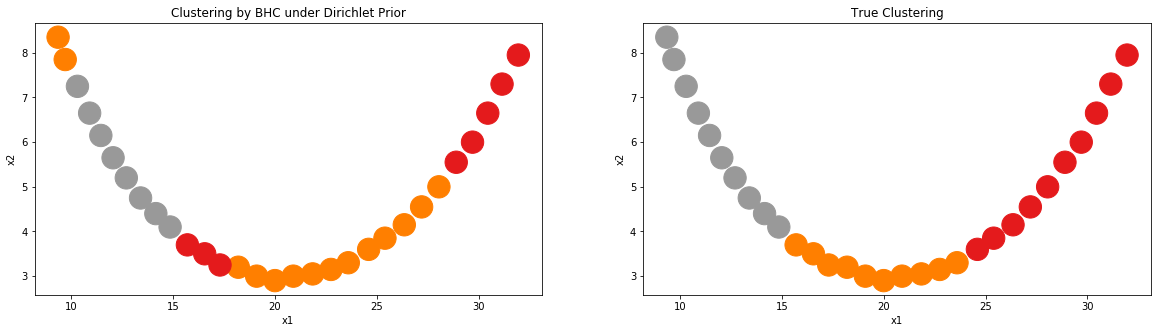

In [800]:
z1 = np.array(ar_spiral_d.iloc[0:30,2])

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
#plt.figure(tight_layout=True, facecolor='white')
plt.scatter(np_spiral_d[:, 0], np_spiral_d[:, 1], c=assigments_d, cmap='Set1',s = 500)
plt.title('Clustering by BHC under Dirichlet Prior')
plt.xlabel('x1')
plt.ylabel('x2')

plt.subplot(1,2,2)
#plt.figure(tight_layout=True, facecolor='white')
plt.scatter(np_spiral_d[:, 0], np_spiral_d[:, 1], c=z1, cmap='Set1',s = 500)
plt.title('True Clustering')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [612]:
assigments_d[assigments_d == 1] = 3
assigments_d[assigments_d == 0] = 1
f1_score(z1, assigments_d,average= 'weighted')

0.6759259259259259

Glass data using Bernoulli prior

In [713]:
glass = pd.read_csv('/Users/zhuangdiezhou/Documents/Course Spring 2019/Statistical Computation/BHC/glass.data', 
                   sep=",",header = None) 

In [715]:
glass.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [716]:
glass_1 = glass[glass.iloc[:,10] == 1]
glass_2 = glass[glass.iloc[:,10] == 2]
glass_3 = glass[glass.iloc[:,10] == 3]

In [717]:
glass_b = pd.concat([glass_1[0:10],glass_2[0:10]])
#normalization
np_glass_b = np.array(glass_b,dtype=None)[:, 0:10]
normed_glass_b = np_glass_b/np_glass_b.sum(axis = 1)[:,None]

In [846]:
%%time
clusters_b2, a_b2=bhc(data=normed_glass_b, alpha = 20)
assigments_b2 = cut_tree_n(2, clusters_b2)

CPU times: user 1.31 s, sys: 8.24 ms, total: 1.32 s
Wall time: 1.35 s


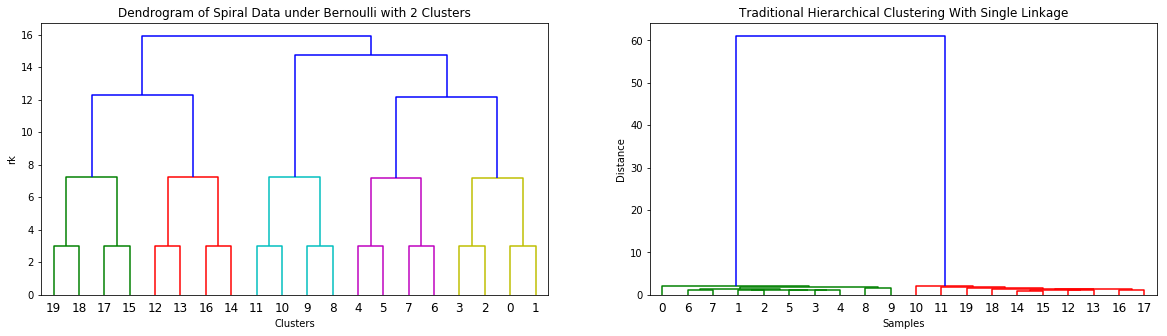

In [847]:
Zd = dendrogram_data(clusters_b2)
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
dendrogram(Zd)
plt.xlabel('Clusters')
plt.ylabel('rk')
plt.title('Dendrogram of Spiral Data under Bernoulli with 2 Clusters')

plt.subplot(1,2,2)
data = np.array(glass_b)
data_dist = pdist(data) # computing the distance
data_link = linkage(data_dist,method='single') # computing the linkage
dendrogram(data_link,labels=data.dtype.names)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.title('Traditional Hierarchical Clustering With Single Linkage');
plt.show()

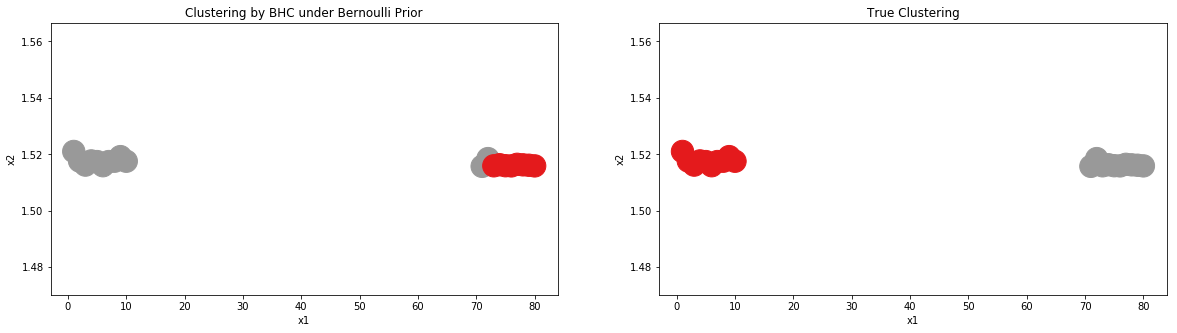

In [851]:
z = np.array(glass_b.iloc[0:40,10])

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.scatter(np_glass_b[:, 0], np_glass_b[:, 1], c=assigments_b2, cmap='Set1',s = 500)
plt.title('Clustering by BHC under Bernoulli Prior')
plt.xlabel('x1')
plt.ylabel('x2')

plt.subplot(1,2,2)
plt.scatter(np_glass_b[:, 0], np_glass_b[:, 1], c=z, cmap='Set1',s = 500)
plt.title('True Clustering')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [854]:
assigments_b2[assigments_b2 == 0] = 2

f1_score(z, assigments_b2)

0.9090909090909091

Glass data using Dirichlet

In [725]:
glass_d = pd.concat([glass_1[0:10],glass_2[0:10],glass_3[0:10]])

In [726]:
np_glass_d = np.array(glass_d,dtype=None)[:, 0:10]
normed_glass_d = np_glass_d/np_glass_d.sum(axis = 1)[:,None]

In [840]:
%%time
clusters_d2, a_d2=bhc(data=normed_glass_d, alpha = 100, beta = 100)
assigments_d2 = cut_tree_n(3, clusters_d2)

CPU times: user 743 ms, sys: 8.87 ms, total: 752 ms
Wall time: 773 ms


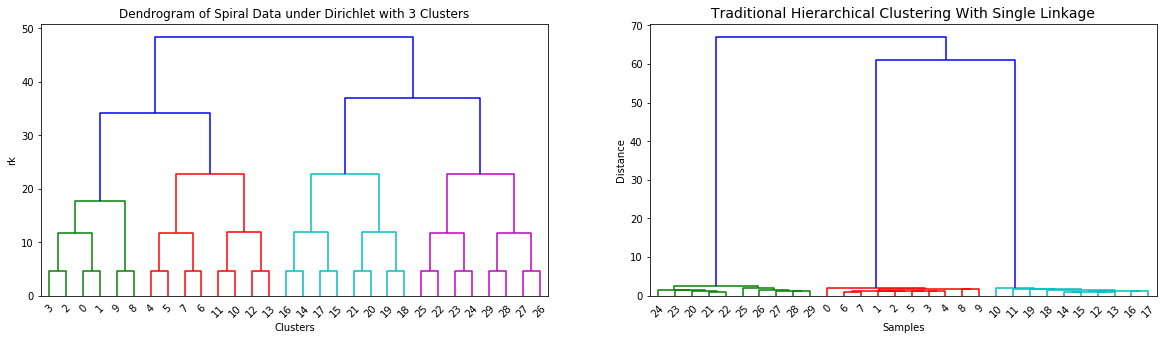

In [830]:
Zd = dendrogram_data(clusters_d2)

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
dendrogram(Zd)
plt.xlabel('Clusters')
plt.ylabel('rk')
plt.title('Dendrogram of Spiral Data under Dirichlet with 3 Clusters')

plt.subplot(1,2,2)
data = np.array(glass_d)
data_dist = pdist(data) # computing the distance
data_link = linkage(data_dist,method='single') # computing the linkage
dendrogram(data_link,labels=data.dtype.names)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.title('Traditional Hierarchical Clustering With Single Linkage', fontsize=14);

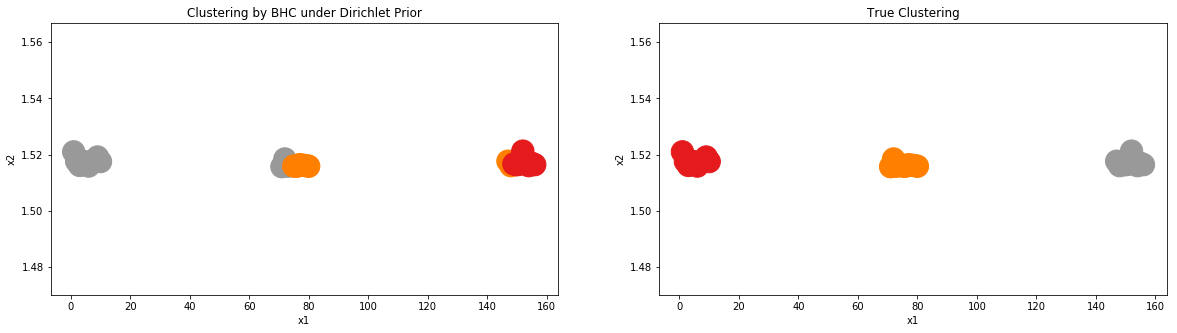

In [841]:
z = np.array(glass_d.iloc[0:30,10])
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.scatter(np_glass_d[:, 0], np_glass_d[:, 1], c=assigments_d2, cmap='Set1',s = 500)
plt.title('Clustering by BHC under Dirichlet Prior')
plt.xlabel('x1')
plt.ylabel('x2')

plt.subplot(1,2,2)
plt.scatter(np_glass_d[:, 0], np_glass_d[:, 1], c=z, cmap='Set1',s = 500)
plt.title('True Clustering')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [844]:
assigments_d2[assigments_d2 == 0] = 3
assigments_d2[assigments_d2 == 2] = 1
assigments_d2[assigments_d2 == 1] = 2
f1_score(z1, assigments_d,average= 'weighted')

0.6759259259259259